# Brain Tumor Detection

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from PIL import Image
# !pip install mat73
import mat73

In [283]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

## Exploratory Data Analysis

### Image example

In [98]:
### Choose any number from 1 to 3046
file_number = 17
file = f'../data/brain-tumor-data-public/{file_number}.mat'

#https://stackoverflow.com/questions/17316880/reading-v-7-3-mat-file-in-python
data_dict = mat73.loadmat(file)

In [99]:
### Patient Id
int(data_dict['cjdata']['PID'])

101127

In [100]:
### Label
# 1 for meningioma, 2 for glioma, 3 for pituitary tumor
int(data_dict['cjdata']['label'])

1

In [101]:
### Image preprocessing
imx = data_dict['cjdata']['image']
imx = imx/imx.max() #Values are not normalized
imx = imx*255 #Scale from 0 to 255
imx = np.round(imx) 
imx = imx.astype(np.uint8) #np datatype for images

im = Image.fromarray(imx)

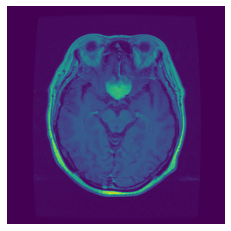

In [102]:
### Image
fig, ax = plt.subplots()
ax.imshow(im)
plt.axis('off');

In [103]:
### Tumor Border (pixels in which there is a tumor)
tumor_border = data_dict['cjdata']['tumorBorder']
tumor_border_x = tumor_border[0::2]
tumor_border_y = tumor_border[1::2]

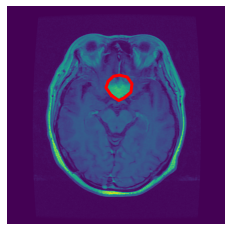

In [104]:
### Border
fig, ax = plt.subplots()
ax.imshow(im)
ax.plot(tumor_border_x, tumor_border_y, color='red', lw=3)
plt.axis('off');

In [105]:
### Tumor Mask (pixels in which there is a tumor)
mask = data_dict['cjdata']['tumorMask']
mask = mask.astype(np.uint8) #np datatype for images
# mask = 1-mask

mask_im = Image.fromarray(mask)

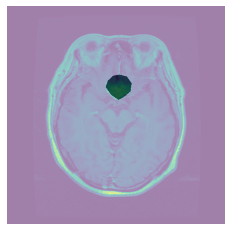

In [106]:
### Mask
fig, ax = plt.subplots()
ax.imshow(im)
ax.imshow(mask_im, cmap='Greys', alpha = 0.5)
plt.axis('off');

### cvind

According to the README file, "the 5-fold cross-validation indices are also provided", and this appear to be stored in this *cvind* file. However, we do not understand what is the author exactly referring to when talking about cross-validation in this context.

In [107]:
file = '../data/cvind.mat'

In [108]:
#https://stackoverflow.com/questions/17316880/reading-v-7-3-mat-file-in-python
data_dict = mat73.loadmat(file)

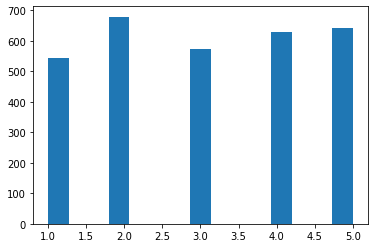

In [109]:
fig, ax = plt.subplots()
ax.hist(data_dict['cvind'], bins = 15);

### Multiple brain images

In [129]:
### Choose 16 numbers from 1 to 3046
random.seed(1234)
file_numbers = random.sample(range(1,3046), 16, )
files = [f'../data/brain-tumor-data-public/{file_number}.mat' for file_number in file_numbers]

data_dicts = [mat73.loadmat(file) for file in files]

In [130]:
### Label
# 1 for meningioma, 2 for glioma, 3 for pituitary tumor
labels = [int(data_dict['cjdata']['label']) for data_dict in data_dicts]
labels

[3, 1, 1, 1, 2, 1, 2, 2, 1, 1, 3, 3, 1, 1, 1, 3]

In [307]:
def imx_preproc(imx, zero_up_to_one=False):
    
    imx = imx/imx.max() #Values were not normalized
    
    if zero_up_to_one:
        return imx
    
    imx = imx*255 #Scale from 0 to 255
    imx = np.round(imx) 
    imx = imx.astype(np.uint8) #np datatype for images
    
    return imx

In [132]:
### Image preprocessing
imxs = [data_dict['cjdata']['image'] for data_dict in data_dicts]
imxs = [imx_preproc(imx) for imx in imxs]

ims = [Image.fromarray(imx) for imx in imxs]

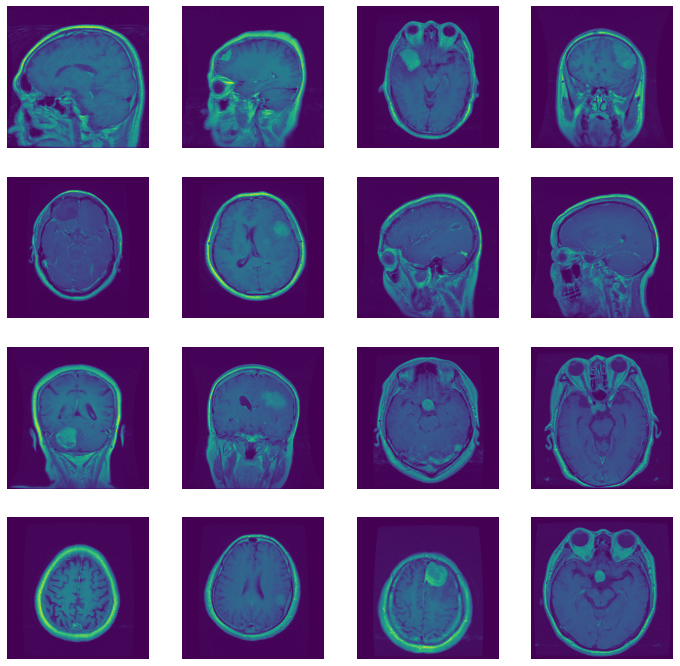

In [135]:
### Image
fig, axs = plt.subplots(4, 4, figsize = (12,12))

k = 0
for i in range(4):
    for j in range(4):
        plt.sca(axs[i,j]); ax = plt.gca()
        ax.imshow(ims[k])
        ax.set_axis_off()        
        k+=1

In [136]:
### Tumor Border (pixels in which there is a tumor)
tumor_borders = [data_dict['cjdata']['tumorBorder'] for data_dict in data_dicts]

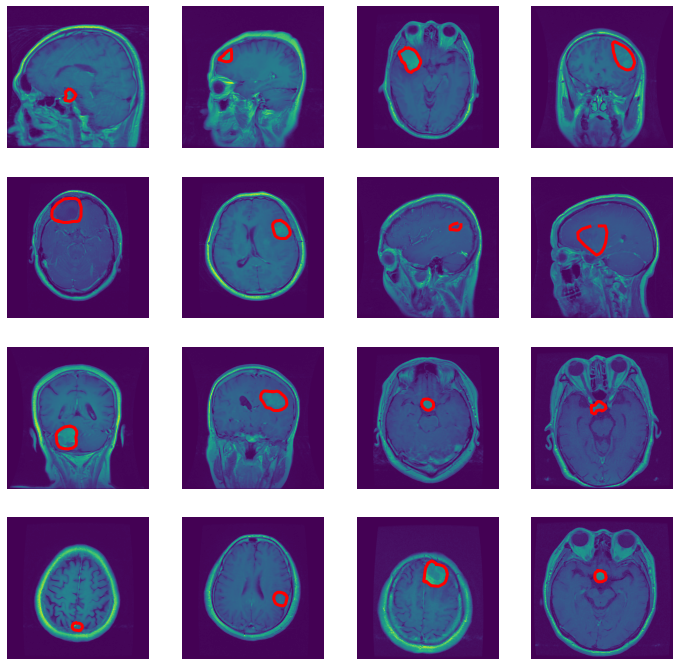

In [138]:
### Border
fig, axs = plt.subplots(4, 4, figsize = (12,12))

k = 0
for i in range(4):
    for j in range(4):
        plt.sca(axs[i,j]); ax = plt.gca()
        ax.imshow(ims[k])
        
        tumor_border = tumor_borders[k]
        tumor_border_x, tumor_border_y = tumor_border[0::2], tumor_border[1::2]
        ax.plot(tumor_border_x, tumor_border_y, color='red', lw=3)
        
        ax.set_axis_off()        
        k+=1

In [139]:
### Tumor Mask (pixels in which there is a tumor)
masks = [data_dict['cjdata']['tumorMask'] for data_dict in data_dicts]

In [105]:
### Tumor Mask (pixels in which there is a tumor)
mask = data_dict['cjdata']['tumorMask']
mask = mask.astype(np.uint8) #np datatype for images
# mask = 1-mask

mask_im = Image.fromarray(mask)

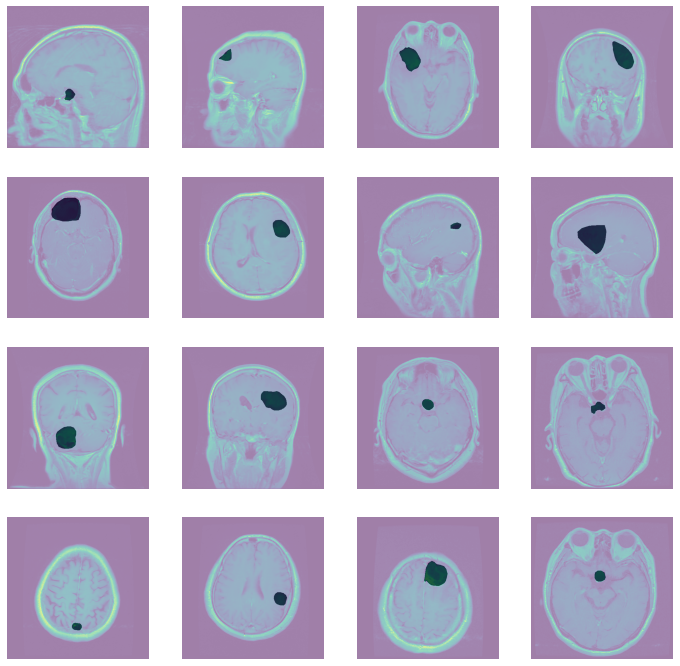

In [140]:
### Mask
fig, axs = plt.subplots(4, 4, figsize = (12,12))

k = 0
for i in range(4):
    for j in range(4):
        plt.sca(axs[i,j]); ax = plt.gca()
        ax.imshow(ims[k])
        
        mask = masks[k]
        mask = mask.astype(np.uint8) #np datatype for images
        mask_im = Image.fromarray(mask)
        ax.imshow(mask_im, cmap='Greys', alpha = 0.5)
        
        ax.set_axis_off()        
        k+=1

### Group by Patient ID

In [303]:
### Load each file independently (to avoid memory overflows) and retriev PID
patient_ids_dict = dict()
label_ids_dict = dict()
shape_x_dict = dict()
shape_y_dict = dict()
image_dict = dict()

for file_number in range(1,3047):
    file = f'../data/brain-tumor-data-public/{file_number}.mat'
    data_dict = mat73.loadmat(file)
    patient_ids_dict[file_number] = data_dict['cjdata']['PID']
    label_ids_dict[file_number] = int(data_dict['cjdata']['label'])
    shape_x_dict[file_number] = data_dict['cjdata']['image'].shape[0]
    shape_y_dict[file_number] = data_dict['cjdata']['image'].shape[1]
    image_dict[file_number] = data_dict['cjdata']['image']

In [305]:
patient_ids = pd.Series(patient_ids_dict)
label_ids = pd.Series(label_ids_dict)
shape_x = pd.Series(shape_x_dict)
shape_y = pd.Series(shape_y_dict)
image = pd.Series(image_dict)

patients = pd.DataFrame({'pid':patient_ids, 'label':label_ids,
                         'x':shape_x, 'y':shape_y, 'image':image}, index=range(1, 3047))

In [306]:
patients

pid  label    x    y  \
1        100360      1  512  512   
2        100360      1  512  512   
3        100360      1  512  512   
4        100360      1  512  512   
5        100360      1  512  512   
...         ...    ...  ...  ...   
3042  MR040240C      2  512  512   
3043  MR040240C      2  512  512   
3044  MR040240C      2  512  512   
3045  MR040240C      2  512  512   
3046  MR040240C      2  512  512   

                                                  image  
1     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
5     [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
...                                                 ...  
3042  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3043  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3044  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3045  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3046  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[3046 rows x 5 columns]

We first apply the `imx_preproc` function to the *image* column in order to normalize it as we want it, and convert it to float:

In [311]:
patients['image'] = patients['image'].apply(lambda x : imx_preproc(x, zero_up_to_one=True))
patients['image'] = patients['image'].apply(lambda x : x.astype('float32'))

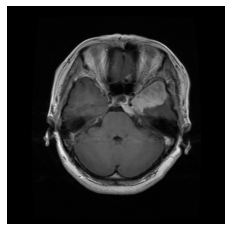

In [360]:
### Example (note we multiply by 255 since we have it on a 0 to 1 scale)
fig, ax = plt.subplots()
im = Image.fromarray(patients['image'].iloc[0]*255)
ax.imshow(im)
plt.axis('off');

The following code shows each patient has a unique label (else, we would have a printed *pid*, as can be seen in the testing cell following this one):

In [361]:
for pid in patients['pid'].unique():    
    if patients[patients['pid'] == pid]['label'].nunique() > 1:
        print(pid)

In [362]:
aux = pd.concat([patients, pd.DataFrame({'pid':['MR040240C'], 'label':[3]}, index = [9999])])

for pid in aux['pid'].unique():    
    if aux[aux['pid'] == pid]['label'].nunique() > 1:
        print(pid)

MR040240C


Also, there are some images that have a dimension of 256x256, when the most common dimension is 512x512.

In [363]:
patients[patients['x'] != 512]

Empty DataFrame
Columns: [pid, label, x, y, image]
Index: []

 These all seem to be associated to one patient, and represent only around 0.5% of the dataset, so we will rather drop them.

In [321]:
print(str(np.round(100*len(patients[patients['x'] != 512])/len(patients), 4))+'%')
patients = patients[patients['x'] == 512]

0.4924%


The MRI count distribution is quite unequal:

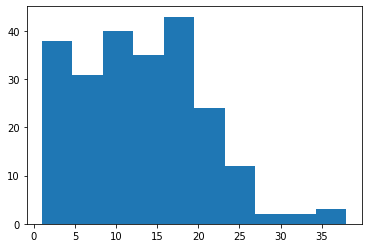

In [322]:
### Distribution of MRI count by PID
fig, ax = plt.subplots()
ax.hist(patients.groupby('pid').count()['label']);

Nonetheless, we would like the model to be able to identify the cancer type with any of the MRI angles, so we will not bother classifying them.

### Analysis fixing a patient

In [323]:
### Choose a PID
pid = '100360'
file_numbers = patients[patients['pid'] == pid].index.tolist()
files = [f'../data/brain-tumor-data-public/{file_number}.mat' for file_number in file_numbers]

data_dicts = [mat73.loadmat(file) for file in files]
n = len(data_dicts)

In [324]:
### Label
# 1 for meningioma, 2 for glioma, 3 for pituitary tumor
labels = [int(data_dict['cjdata']['label']) for data_dict in data_dicts]
labels

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [325]:
### Image preprocessing
imxs = [data_dict['cjdata']['image'] for data_dict in data_dicts]
imxs = [imx_preproc(imx) for imx in imxs]

ims = [Image.fromarray(imx) for imx in imxs]

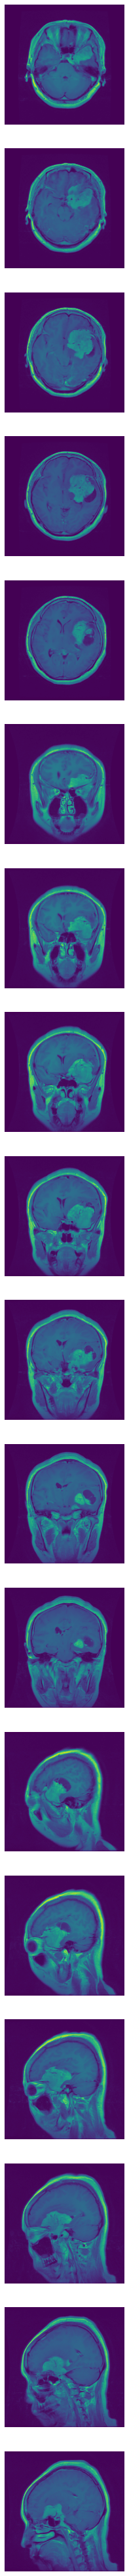

In [326]:
### Image
fig, axs = plt.subplots(n, 1, figsize = (12,n*4))

k = 0
for i in range(n):    
    plt.sca(axs[k]); ax = plt.gca()
    ax.imshow(ims[k])
    ax.set_axis_off()        
    k+=1

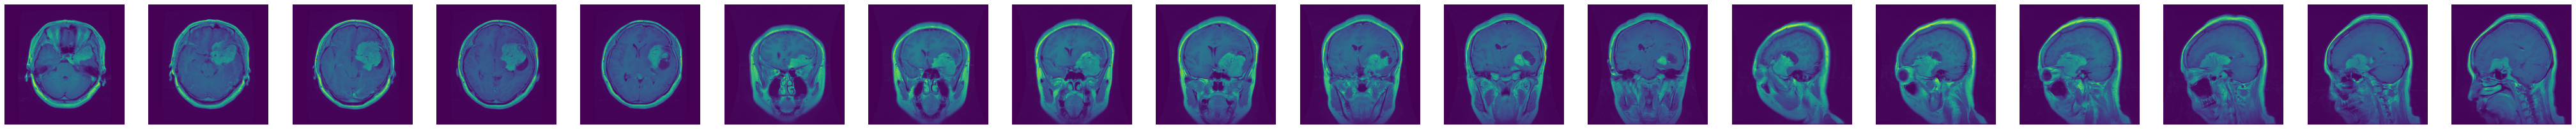

In [245]:
### Image
fig, axs = plt.subplots(1,n, figsize = (n*4, 6))

k = 0
for i in range(n):    
    plt.sca(axs[k]); ax = plt.gca()
    ax.imshow(ims[k])
    ax.set_axis_off()        
    k+=1

In [238]:
### Tumor Border (pixels in which there is a tumor)
tumor_borders = [data_dict['cjdata']['tumorBorder'] for data_dict in data_dicts]

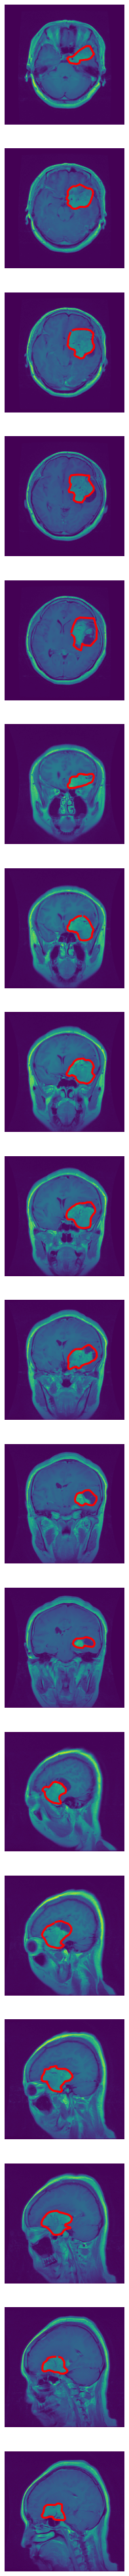

In [242]:
### Border
fig, axs = plt.subplots(n, 1, figsize = (12,n*4))

k = 0
for i in range(n):    
    plt.sca(axs[k]); ax = plt.gca()
    ax.imshow(ims[k])

    tumor_border = tumor_borders[k]
    tumor_border_x, tumor_border_y = tumor_border[0::2], tumor_border[1::2]
    ax.plot(tumor_border_x, tumor_border_y, color='red', lw=3)

    ax.set_axis_off()        
    k+=1

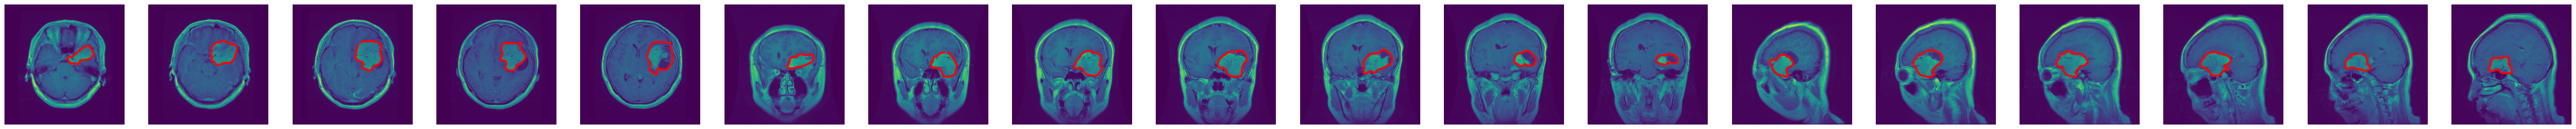

In [247]:
### Border
fig, axs = plt.subplots(1, n, figsize = (n*4, 6))

k = 0
for i in range(n):    
    plt.sca(axs[k]); ax = plt.gca()
    ax.imshow(ims[k])

    tumor_border = tumor_borders[k]
    tumor_border_x, tumor_border_y = tumor_border[0::2], tumor_border[1::2]
    ax.plot(tumor_border_x, tumor_border_y, color='red', lw=3)

    ax.set_axis_off()        
    k+=1

In [248]:
### Tumor Mask (pixels in which there is a tumor)
masks = [data_dict['cjdata']['tumorMask'] for data_dict in data_dicts]

In [249]:
### Tumor Mask (pixels in which there is a tumor)
mask = data_dict['cjdata']['tumorMask']
mask = mask.astype(np.uint8) #np datatype for images
# mask = 1-mask

mask_im = Image.fromarray(mask)

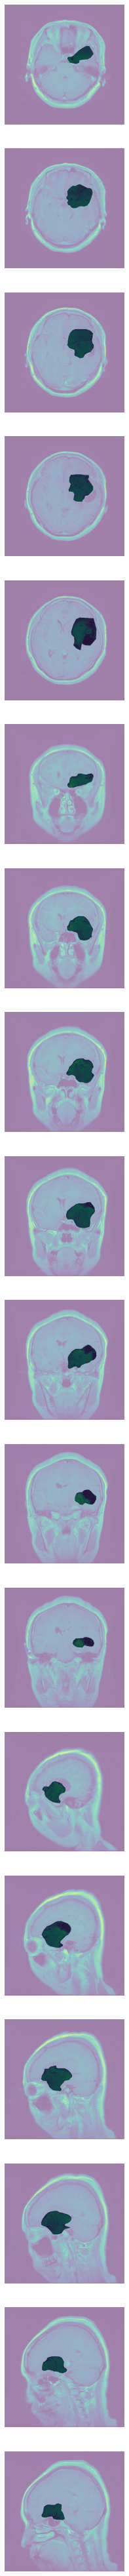

In [250]:
### Mask
fig, axs = plt.subplots(n, 1, figsize = (12,n*4))

k = 0
for i in range(n):
    plt.sca(axs[k]); ax = plt.gca()
    ax.imshow(ims[k])

    mask = masks[k]
    mask = mask.astype(np.uint8) #np datatype for images
    mask_im = Image.fromarray(mask)
    ax.imshow(mask_im, cmap='Greys', alpha = 0.5)

    ax.set_axis_off()        
    k+=1

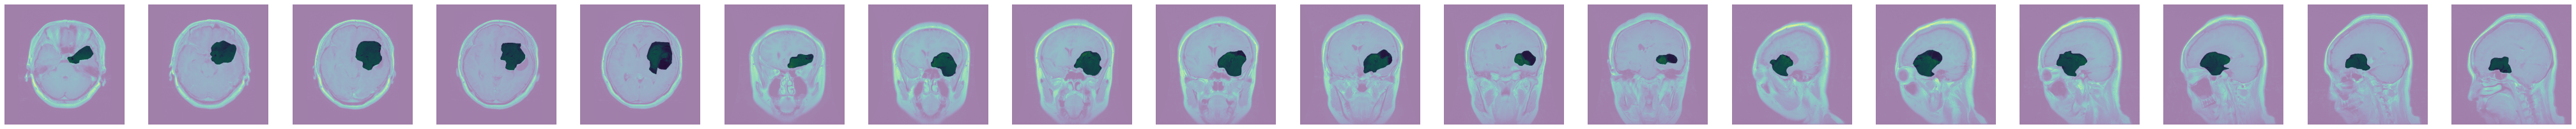

In [251]:
### Mask
fig, axs = plt.subplots(1, n, figsize = (n*4, 6))

k = 0
for i in range(n):
    plt.sca(axs[k]); ax = plt.gca()
    ax.imshow(ims[k])

    mask = masks[k]
    mask = mask.astype(np.uint8) #np datatype for images
    mask_im = Image.fromarray(mask)
    ax.imshow(mask_im, cmap='Greys', alpha = 0.5)

    ax.set_axis_off()        
    k+=1

## Train and Validation Sets

In [425]:
random.seed(1234)
train_set, val_set = train_test_split(patients, stratify=patients['label'], test_size=0.3)

n_total_train = train_set.shape[0]

train_set_x = np.stack(train_set['image'].values)
train_set_y = np.array(train_set['label'])

val_set_x = np.stack(val_set['image'].values)
val_set_y = np.array(val_set['label'])

In [449]:
### A possible alternative, though it did not seem to help that much
### https://www.tensorflow.org/tutorials/load_data/numpy

# train_dataset = tf.data.Dataset.from_tensor_slices((train_set_x, train_set_y))
# test_dataset = tf.data.Dataset.from_tensor_slices((val_set_x, val_set_y))

# BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 20

# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)

In [444]:
print(train_set_x.shape)
print(val_set_x.shape)

(2121, 512, 512)
(910, 512, 512)


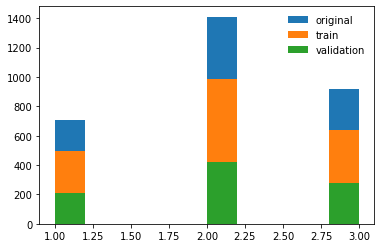

In [429]:
fig, ax = plt.subplots()
ax.hist(patients['label'], label='original')
ax.hist(train_set['label'], label='train')
ax.hist(val_set['label'], label='validation')
plt.legend(frameon=False);

## CNN Implementation

In [451]:
batch_size = 64
IMG_H = 512
IMG_W = 512

In [452]:
CNN = Sequential([
    InputLayer(input_shape=(IMG_H, IMG_W, 1)),
    
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

CNN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 510, 510, 64)      640       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 255, 255, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 253, 253, 64)      36928     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 126, 126, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 62, 62, 64)     

In [453]:
# Compile: Define training parameters
CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [454]:
# Train model
EPOCHS = 10
BATCHES = n_total_train//batch_size

### Following line overflows memory
# CNN.fit(train_set_x, train_set_y, steps_per_epoch=BATCHES, epochs=EPOCHS, validation_data=(val_set_x, val_set_y))

### Following line can still not be run because we do not have images as jpg in specific folders
# CNN.fit(train_generator, steps_per_epoch=BATCHES, epochs=EPOCHS, validation_data=val_generator)

### Following line was thought to be a solution to the memory running out, but it wasn't
# CNN.fit(train_dataset, epochs=10)

Epoch 1/10
 1/34 [..............................] - ETA: 19:43 - loss: 0.6416 - accuracy: 0.1406

KeyboardInterrupt: 

## Next Steps

We face a problem at the moment: The method we were trying to implement to generate samples from training and validations requires us to have the images as .jpg files and separated in folders. We tried to circumvent this by loading the training and validation data as `np.array`s, however, this overflows the memory.

We need to either convert the files to jpg and store them in the required way, or to find a way to use `np.array`s more efficiently